In [1]:
library("AnnotationDbi")
library("org.Hs.eg.db")
library(RUVSeq)
source("downstreamAnalysis_RNAseqFunctions.R")

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The f

In [2]:
# Read in data

cts = as.matrix(read.csv("../../data/cts_nsqip.csv", sep=',', row.names=1))
coldata = read.csv('../../data/coldata_nsqip.csv', sep=',', row.names=1)

dim(coldata)
dim(cts)


[1] 110 111

[1] 14664   110

In [3]:
table(coldata$IASC)


 No Yes 
 99  11 

In [4]:
factor_cols = c('sex', 'disease', 'batch', 'SSI', 'IASC')
for (col in factor_cols) {
  coldata[,col] = as.factor(coldata[,col])
}

sex = coldata$sex
SSI = coldata$SSI
any = coldata$any
IASC = coldata$IASC
batch = coldata$batch
full_batch = coldata$fullBatch
subtype = coldata$subtype
tin = coldata$TIN_med_new
# date = coldata$sampleDate
disease = coldata$disease

sample = rownames(coldata)

#round counts to integers
cts <- round(cts);

#check if row names of coldata match colnames of cts
all(rownames(coldata) == colnames(cts))

#adjust for batch and sexBin
design <- as.formula(~ IASC)
#create the dds object
dds = DESeqDataSetFromMatrix(countData = cts, colData = coldata, design = design)

[1] TRUE

converting counts to integer mode



In [11]:

# #save the plot
# png("results/i/pca_source_raw.png", width=1024, height=512)
# ggplot(pcaData, aes(PC1, PC2, color=source, shape=recur)) +
#     geom_point(size=5) +
#     #geom_text(aes(label=sample),hjust=0, vjust=0) +
#     xlab(paste0("PC1: ",percentVar[1],"% variance")) +
#     ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
#     coord_fixed() +
    
#     theme(text = element_text(size = 24))
# dev.off()

In [5]:
library('GenomicFeatures')
#use the GenomicFeatures package to create a transcript database (txDb) file from our GENCODE annotation file, and use it to pull out the chromosomal coordinates for each of our transcripts (including which chromosome it is on)
txdb = makeTxDbFromGFF('../../data/gencode.v39.annotation.gtf', dbxrefTag = "gene_id", organism = 'Homo sapiens')
k <- keys(txdb, keytype = 'TXNAME')
tx2gene <- AnnotationDbi::select(txdb, keys=k, columns=c('GENEID', 'TXCHROM', 'TXSTART', 'TXEND', 'TXSTRAND'), keytype='TXNAME')
# make a subset of the list containing only the Ensembl gene IDs and the names of the chromosomes, and create a subset for all the genes on chromosomes X and Y
tx2gene_short = tx2gene[,2:3]
tx2gene_short = unique(tx2gene_short)
tx2gene_short_xychrom = tx2gene_short[tx2gene_short$TXCHROM=="chrX" | tx2gene_short$TXCHROM=="chrY",]

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK

'select()' returned 1:1 mapping between keys and columns



In [6]:
#now remove the rows from cts if they are present in 'GENEID' in tx2gene_short_xychrom
cts <- cts[! match(rownames(cts), tx2gene_short_xychrom$GENEID, nomatch=0),]
dim(cts)

[1] 14664   110

In [7]:
#DESeq on the raw data to identify control genes
#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=IASC)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]

dds <- DESeq(dds)
res <- results(dds)
table(res$pvalue < 0.5)

keep
 TRUE 
14664 

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 55 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




FALSE  TRUE 
 8370  6294 

In [8]:
set <- newSeqExpressionSet(counts(dds))
set <- betweenLaneNormalization(set, which='upper')
not_sig <- rownames(res)[which(res$pvalue > 0.5)]
empirical <- rownames(set)[ rownames(set) %in% not_sig ]
set <- RUVg(set, empirical, k=20)
pdat <- pData(set)
pdat$IASC <- IASC
pdat$sex <- sex

In [10]:
formula_list = list(
~ sex + W_1 + IASC, 
~ sex + W_1 + W_2 + IASC, 
~ sex + W_1 + W_2 + W_3 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + IASC, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + IASC,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + W_20 + IASC)



#create an empty dataframe to store the number of significant genes
deg_counts = data.frame(matrix(ncol=20, nrow=0))
colnames(deg_counts) = c("formula", "sig_genes")

for (x in seq_along(formula_list)) {
    design_formula = formula(formula_list[[x]])
    dds1 <- DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
    y <- DGEList(counts=counts(dds1), group=coldata$IASC)
    keep <- filterByExpr(y)
    table(keep)
    y <- y[keep,]
    dds1 <- dds1[keep,]
    dds1 <- DESeq(dds1)
    res <- results(dds1)
    res <- res[order(res$padj),]
    #get the number of significant genes
    sig_genes <- res[which(res$padj < 0.05),]
    #save the number of significant genes to the dataframe
    deg_counts = rbind(deg_counts, c(x, nrow(sig_genes)))
    #save the results to a csv file
    write.csv(res, paste0("../../results/post_op/ruvg_runs_iasc/res5_", x, ".csv"))
}

head(deg_counts, 10)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and test

,X1L,X2L
,<int>,<int>
1,1,2
2,2,3
3,3,2
4,4,2
5,5,2
6,6,2
7,7,2
8,8,2
9,9,1


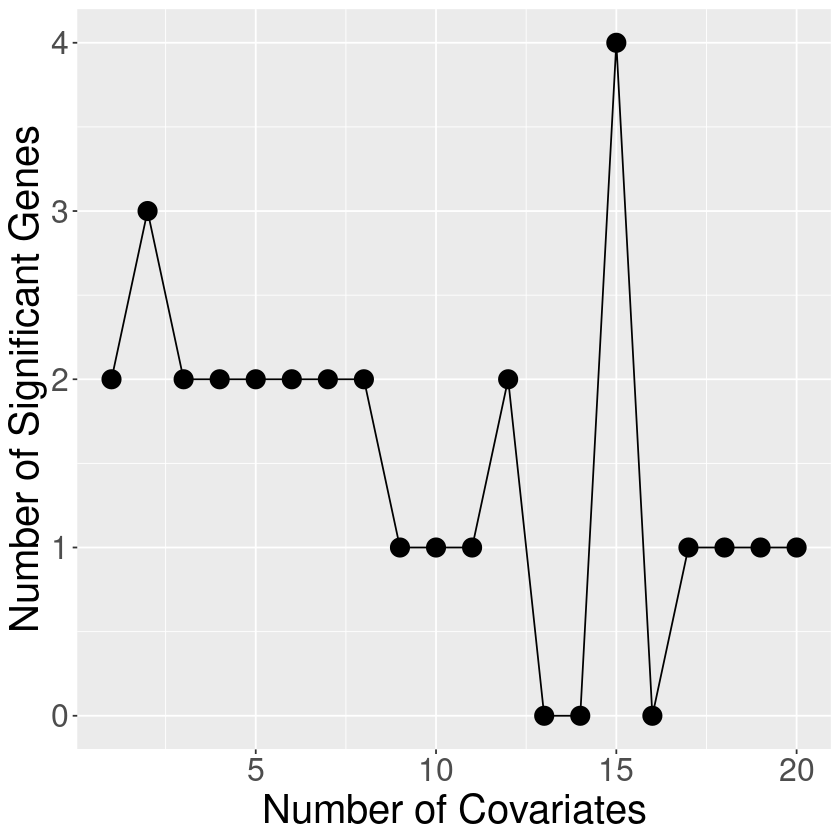

In [11]:
colnames(deg_counts) = c("formula", "sig_genes")
#plot the number of significant genes vs the number of covariates
ggplot(deg_counts, aes(x=formula, y=sig_genes)) +
    geom_point(size=5) +
    geom_line() +
    xlab("Number of Covariates") +
    ylab("Number of Significant Genes") +
    theme(text = element_text(size = 24))
#save the plot
ggsave("../../results/post_op/ruvg_runs_iasc/deg_counts5.png", width=10, height=10)

In [12]:
#use 4 covariates
design_formula = formula(formula_list[[15]])
design_formula
dds = DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=IASC)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]
#run DESeq
dds <- DESeq(dds)
res <- results(dds)
resOrdered <- res[order(res$padj),]
head(resOrdered)

~sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + 
    W_10 + W_11 + W_12 + W_13 + W_14 + +W_15 + IASC

converting counts to integer mode



keep
 TRUE 
14664 

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): IASC Yes vs No 
Wald test p-value: IASC Yes vs No 
DataFrame with 6 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat      pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>   <numeric> <numeric>
MTND1P23 1493.1328       3.493713 0.7192769   4.85726 1.19023e-06 0.0174535
WIPF1     854.2593       0.325771 0.0744150   4.37776 1.19907e-05 0.0447104
TAGAP     273.6969       0.445594 0.1015404   4.38834 1.14217e-05 0.0447104
PASK      254.2464       0.398174 0.0910310   4.37406 1.21960e-05 0.0447104
PELO      250.5227      -0.265544 0.0665997  -3.98716 6.68688e-05 0.0975110
FBXO41     79.0877       0.436434 0.1106215   3.94529 7.97046e-05 0.0975110

In [ ]:
library('pheatmap')
library('genefilter')
#use RemoveBatchEffect to adjust for the identified covariates
#first create variables for each of the RUV factors
ruv1 = pdat$W_1
ruv2 = pdat$W_2
ruv3 = pdat$W_3
ruv4 = pdat$W_4
ruv5 = pdat$W_5
ruv6 = pdat$W_6
ruv7 = pdat$W_7
ruv8 = pdat$W_8
ruv9 = pdat$W_9
ruv10 = pdat$W_10
ruv11 = pdat$W_11
ruv12 = pdat$W_12
ruv13 = pdat$W_13

#run RemoveBatchEffect using the RUV factors and sex
vsd = vst(dds)
mat= assay(vsd)
assay(vsd) <- removeBatchEffect(assay(vsd), batch=sex, covariates=cbind(ruv1, ruv2, ruv3, ruv4, ruv5, ruv6, ruv7, ruv8, ruv9, ruv10, ruv11, ruv12, ruv13))
resOrdered <- res[order(res$padj),]
resOrdered$gene <- rownames(resOrdered)
resOrdered = resOrdered[,c(7, 1, 2, 3, 4, 5, 6)]
head(resOrdered)


In [ ]:
#make a list of the top 15 genes
top15 <- resOrdered[1:15,]
recur <- data.frame(recur=coldata$recur)
rownames(recur) <- colnames(mat)
mat15 <- mat[top15$gene,]
#center the data
mat15 <- mat15 - rowMeans(mat15)
head(mat15)

In [ ]:
#sort each dataframe by recurrence
#first sort the annotation data by recurrence while keeping it as a dataframe
recur <- recur[order(recur$recur), , drop=FALSE]
#then sort the matrix by the order of the annotation data by getting the rownames of the annotation data and reordering the columns of the matrix
col_order = rownames(recur)
mat15 <- mat15[,col_order]
#remove the sample names from the heatmap
pheatmap(mat15, annotation_col=recur, cluster_cols=F, show_colnames=F, filename='../../results/post_op/ruvg_runs_iasc/heatmap.png', height=10, width=10)

In [ ]:
formula_list = list(
~ sex + W_1 + iasc, 
~ sex + W_1 + W_2 + iasc, 
~ sex + W_1 + W_2 + W_3 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + iasc, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + iasc,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + W_20 + iasc)



#create an empty dataframe to store the number of significant genes
deg_counts = data.frame(matrix(ncol=20, nrow=0))
colnames(deg_counts) = c("formula", "sig_genes")

for (x in seq_along(formula_list)) {
    design_formula = formula(formula_list[[x]])
    dds1 <- DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
    y <- DGEList(counts=counts(dds1), group=coldata$iasc)
    keep <- filterByExpr(y)
    table(keep)
    y <- y[keep,]
    dds1 <- dds1[keep,]
    dds1 <- DESeq(dds1)
    res <- results(dds1)
    res <- res[order(res$padj),]
    #get the number of significant genes
    sig_genes <- res[which(res$padj < 0.05),]
    #save the number of significant genes to the dataframe
    deg_counts = rbind(deg_counts, c(x, nrow(sig_genes)))
    #save the results to a csv file
    write.csv(res, paste0("results/ruvg_runs/res5_", x, "_iasc.csv"))
}

head(deg_counts, 10)
colnames(deg_counts) = c("formula", "sig_genes")
#plot the number of significant genes vs the number of covariates
ggplot(deg_counts, aes(x=formula, y=sig_genes)) +
    geom_point(size=5) +
    geom_line() +
    xlab("Number of Covariates") +
    ylab("Number of Significant Genes") +
    theme(text = element_text(size = 24))
#save the plot
ggsave("../../results/post_op/ruvg_runs_iasc/deg_counts5_iasc.png", width=10, height=10)


In [ ]:
#use 18 covariates
design_formula = formula(formula_list[[13]])
design_formula
dds = DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
#filter genes for low expreiascon with edgeR
y <- DGEList(counts=counts(dds), group=recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]
#run DESeq
dds <- DESeq(dds)
res <- results(dds)

library('pheatmap')
library('genefilter')
#use RemoveBatchEffect to adjust for the identified covariates
#first create variables for each of the RUV factors
ruv1 = pdat$W_1
ruv2 = pdat$W_2
ruv3 = pdat$W_3
ruv4 = pdat$W_4
ruv5 = pdat$W_5
ruv6 = pdat$W_6
ruv7 = pdat$W_7
ruv8 = pdat$W_8
ruv9 = pdat$W_9
ruv10 = pdat$W_10
ruv11 = pdat$W_11
ruv12 = pdat$W_12
ruv13 = pdat$W_13

#run RemoveBatchEffect using the RUV factors and sex
vsd = vst(dds)
mat= assay(vsd)
assay(vsd) <- removeBatchEffect(assay(vsd), batch=sex, covariates=cbind(ruv1, ruv2, ruv3, ruv4, ruv5, ruv6, ruv7, ruv8, ruv9, ruv10, ruv11, ruv12, ruv13))
resOrdered <- res[order(res$padj),]
resOrdered$gene <- rownames(resOrdered)
resOrdered = resOrdered[,c(7, 1, 2, 3, 4, 5, 6)]
head(resOrdered)

#make a list of the top 15 genes
top15 <- resOrdered[1:15,]
recur <- data.frame(recur=coldata$recur)
rownames(recur) <- colnames(mat)
mat15 <- mat[top15$gene,]
#center the data
mat15 <- mat15 - rowMeans(mat15)
head(mat15)
#sort each dataframe by recurrence
#first sort the annotation data by recurrence while keeping it as a dataframe
recur <- recur[order(recur$recur), , drop=FALSE]
#then sort the matrix by the order of the annotation data by getting the rownames of the annotation data and reordering the columns of the matrix
col_order = rownames(recur)
mat15 <- mat15[,col_order]
#remove the sample names from the heatmap
pheatmap(mat15, annotation_col=recur, cluster_cols=F, show_colnames=F, filename='../../results/post_op/ruvg_runs_iasc/heatmap.png', height=10, width=10)